# Calculate forward kinematics of Baxter arm
## Use DH parameters
- From [Kinematics & Dynamics Library for Baxter Arm](https://doi.org/10.48550/arXiv.2409.00867)
- Use numpy for matrix operations
- For calculation, get transformation for each state
- Multiply all transformations to get end-effector pose
- **Note that the DH parameters given are for left arm, further work will be done for right arm**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
DH_BAXTER = np.array([
    # d,        a,      alpha
    [0.27035,   0.069,  -np.pi/2],  # Link 1 (S0-S1)
    [0.0,       0.0,     np.pi/2],  # Link 2 (S1-E0)
    [0.36435,   0.069,  -np.pi/2],  # Link 3 (E0-E1)
    [0.0,       0.0,     np.pi/2],  # Link 4 (E1-W0)
    [0.37429,   0.01,   -np.pi/2],  # Link 5 (W0-W1)
    [0.0,       0.0,     np.pi/2],  # Link 6 (W1-W2)
    [0.229525,  0.0,     0.0]       # Link 7 (W2-EE)
])

# We also need the theta offsets (second column)
THETA_OFFSETS_BAXTER = np.array([
    0.0,
    np.pi/2,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
])

In [ ]:
def get_tmatrix(d, a, alpha, theta):
    """Compute the individual transformation matrix using DH parameters."""
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])
def calculate_fk(joint_angles):
    T_final = np.eye(4)
    
    # Iterate through each joint
    for i in range(len(joint_angles)):
        # Get the parameters for this link
        q = joint_angles[i] + THETA_OFFSETS_BAXTER[i] # Add the offset
        d, a, alpha = DH_BAXTER[i]
        
        # Get the transformation matrix for this link
        T_link = get_tmatrix(d, a, alpha, q)
        # Cumultatively multiply to get the final transformation
        T_final = T_final @ T_link
        
    return T_final

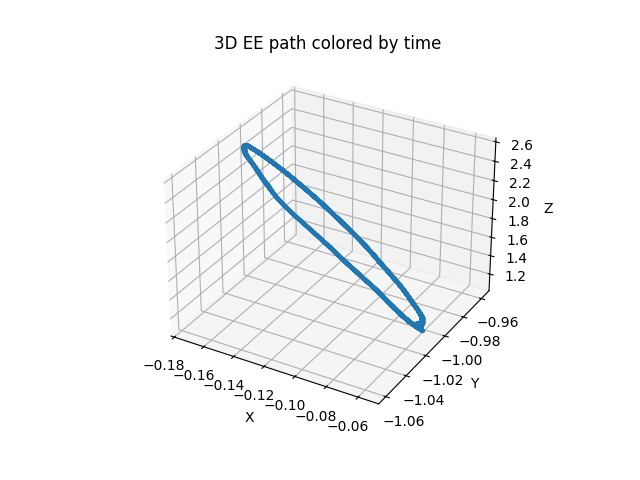

In [31]:
%matplotlib widget
# Only for left arm
df = pd.read_csv("../datasets/baxter/left_circle_p-15_t105.csv", sep=" ")

angles = df[[c for c in df.columns if "ang" in c]]
ee_positions = []
for rows in angles.itertuples(index=False):
    joint_angles = np.array(rows)
    T_ee = calculate_fk(joint_angles)
    ee_positions.append(T_ee[:3, 3])  # Extract the position part
ee_positions = np.array(ee_positions)
times = np.arange(len(ee_positions))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(ee_positions[:,0], ee_positions[:,1], ee_positions[:,2], s=4)#, c=times, cmap='viridis')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D EE path colored by time')
# cbar = fig.colorbar(sc, ax=ax, pad=0.1)
plt.show()

In [24]:
print(df.columns)
print(angles.head())
print(angles.describe())
print(times[:10])

Index(['ang_s0', 'ang_s1', 'ang_e0', 'ang_e1', 'ang_w0', 'ang_w1', 'ang_w2',
       'vel_s0', 'vel_s1', 'vel_e0', 'vel_e1', 'vel_w0', 'vel_w1', 'vel_w2',
       'torq_s0', 'torq_s1', 'torq_e0', 'torq_e1', 'torq_w0', 'torq_w1',
       'torq_w2'],
      dtype='object')
    ang_s0    ang_s1    ang_e0   ang_e1    ang_w0    ang_w1   ang_w2
0  1.48336 -0.658461 -0.430665  1.84308  0.668049  0.674185  1.38595
1  1.48336 -0.656927 -0.431049  1.83924  0.667665  0.675719  1.38672
2  1.48451 -0.656544 -0.431816  1.83656  0.666515  0.677636  1.38825
3  1.48489 -0.655393 -0.432583  1.83426  0.666131  0.678786  1.38940
4  1.48489 -0.653859 -0.432966  1.83234  0.665364  0.680704  1.39017
             ang_s0        ang_s1        ang_e0        ang_e1        ang_w0  \
count  14906.000000  14906.000000  14906.000000  14906.000000  14906.000000   
mean       1.100137     -0.596945     -0.401991      1.627658      0.600112   
std        0.252181      0.174887      0.067352      0.412330      0.105609   
mi